In [ ]:
import os
import sys

def quiet_install(packages):
    install_output = os.popen(f'pip install {packages} 2>&1').read()
    if "Successfully installed" in install_output:
        print("Done")
    else:
        print("Fail")

quiet_install("supervision jupyter_bbox_widget")

Done


In [ ]:
# Clone SAM2 repository
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (426/426), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 1057 (delta 273), reused 248 (delta 248), pack-reused 631 (from 2)
Receiving objects: 100% (1057/1057), 121.74 MiB | 17.89 MiB/s, done.
Resolving deltas: 100% (384/384), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0

In [ ]:
# Essential imports for data manipulation and analysis
import os  # Operating system interface
import cv2  # OpenCV library for image processing
import json  # JSON handling for data serialization
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.patches import Rectangle, Polygon  # Shapes for visualization
from PIL import Image  # Python Imaging Library for image handling
import cv2  # OpenCV library (duplicate import)
import torch  # PyTorch deep learning framework

# Utility imports
from datetime import datetime  # Date and time handling
from pathlib import Path  # Object-oriented filesystem paths
from google.colab import files  # Google Colab file operations

# SAM2 (Segment Anything Model 2) specific imports
from sam2.build_sam import build_sam2  # SAM2 model architecture builder
from sam2.sam2_image_predictor import SAM2ImagePredictor  # SAM2 prediction interface

In [ ]:
import subprocess

HOME = os.getcwd()

def download_checkpoints():
    checkpoint_dir = os.path.join(HOME, 'checkpoints')

    os.makedirs(checkpoint_dir, exist_ok=True)
    os.chdir(checkpoint_dir)

    try:
        result = subprocess.run(['./download_ckpts.sh'],
                              capture_output=True,
                              text=True)

        if result.returncode == 0:
            print("Done")
        else:
            print("Fail")

    except Exception as e:
        print("Fail")

    finally:
        os.chdir(HOME)

download_checkpoints()

Done


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints
%cd {HOME}

/content/segment-anything-2


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

def unzip_enhanced_file():
    zip_path = "/content/drive/MyDrive/enhanced-20241028T214944Z-001.zip"
    extract_path = "/content/"

    try:
        # Check if zip file exists
        if not os.path.exists(zip_path):
            print("❌ Zip file not found at specified path")
            return

        # Create extraction directory if it doesn't exist
        os.makedirs(extract_path, exist_ok=True)

        # Extract zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print("✓ Files extracted successfully to /content/")

    except zipfile.BadZipFile:
        print("❌ Invalid or corrupted zip file")
    except Exception as e:
        print(f"❌ Error during extraction: {str(e)}")

unzip_enhanced_file()

✓ Files extracted successfully to /content/


In [ ]:
import gc
from tqdm import tqdm

def setup_sam2():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
    config = "sam2_hiera_l.yaml"

    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        if torch.cuda.get_device_properties(0).major >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
        sam2_model = build_sam2(config, checkpoint, device=device, apply_postprocessing=False)
    return sam2_model, device

def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path, usecols=['image', 'xmin', 'ymin', 'xmax', 'ymax', 'label'])
    df['image'] = df['image'].str.replace('.jpg', '.png')
    df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(np.float32)
    grouped = df.groupby('image')
    return grouped, df['label'].unique().tolist(), len(grouped)

@torch.inference_mode()
def process_image(image_path, boxes, labels, predictor):
    with torch.autocast(device_type="cuda"):  # Updated autocast usage
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            print(f"Failed to load image: {image_path}")
            return None, None, None

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        predictor.set_image(image_rgb)

        masks = []
        processed_labels = []

        for box, label in zip(boxes, labels):
            box_coords = box.reshape(1, 4)
            mask, _, _ = predictor.predict(box=box_coords, multimask_output=False)
            masks.append(mask.squeeze())
            processed_labels.append(label)

        del image_bgr, image_rgb
        torch.cuda.empty_cache()
        gc.collect()

        return np.array(masks), processed_labels

def create_coco_annotation(image_id, mask, bbox, category_id, annotation_id, label):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    for contour in contours:
        if len(contour) > 2:
            segmentation.append(contour.astype(float).flatten().tolist())

    if not segmentation:
        x, y, w, h = bbox
        segmentation.append([x, y, x+w, y, x+w, y+h, x, y+h])

    return {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "category_name": label,
        "segmentation": segmentation,
        "area": float(mask.sum()),
        "bbox": [float(bbox[0]), float(bbox[1]), float(bbox[2]-bbox[0]), float(bbox[3]-bbox[1])],
        "iscrowd": 0
    }

def process_batch(batch_data, predictor, output_dir, start_image_id, start_annotation_id):
    coco_annotations = []
    processed_count = 0
    current_annotation_id = start_annotation_id

    for image_id, (image_name, group) in enumerate(batch_data, start=start_image_id):
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        boxes = group[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = group['label'].values

        masks, processed_labels = process_image(image_path, boxes, labels, predictor)
        if masks is None:
            continue

        for mask, bbox, label in zip(masks, boxes, processed_labels):
            ann = create_coco_annotation(image_id, mask, bbox, category_map[label], current_annotation_id, label)
            coco_annotations.append(ann)
            current_annotation_id += 1

        processed_count += 1
        if processed_count % 5 == 0:
            torch.cuda.empty_cache()
            gc.collect()

        del masks
        torch.cuda.empty_cache()

    return coco_annotations, current_annotation_id

base_path = "/content/drive/MyDrive/Coral-Reef-Research"
image_dir = "/content/enhanced"
bbox_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
output_dir = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results"

os.makedirs(output_dir, exist_ok=True)

sam2_model, device = setup_sam2()
predictor = SAM2ImagePredictor(sam2_model)
bbox_data, categories, total_images = load_bbox_data(bbox_csv)

category_map = {cat: i for i, cat in enumerate(categories)}

with open(os.path.join(output_dir, "label_mapping.json"), 'w') as f:
    json.dump(category_map, f)

batch_size = 10
current_image_id = 0
current_annotation_id = 0

print(f"Total images in enhanced folder: {len(os.listdir(image_dir))}")
print(f"Total images in CSV: {total_images}")

total_batches = (total_images + batch_size - 1) // batch_size
for batch_start in tqdm(range(0, total_images, batch_size), total=total_batches, desc="Processing images"):
    batch = list(bbox_data)[batch_start:batch_start + batch_size]

    annotations, next_annotation_id = process_batch(
        batch, predictor, output_dir, current_image_id, current_annotation_id
    )

    if len(annotations) > 0:
        with open(os.path.join(output_dir, f"annotations_batch_{batch_start}.json"), 'w') as f:
            json.dump(annotations, f)

    current_annotation_id = next_annotation_id
    current_image_id += len(batch)

    del annotations
    torch.cuda.empty_cache()
    gc.collect()

Total images in enhanced folder: 133
Total images in CSV: 133


Processing images: 100%|██████████| 14/14 [03:01<00:00, 12.94s/it]


In [ ]:
import os

def list_available_images(image_dir):
    """List all images in the directory"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
    images = []
    for file in os.listdir(image_dir):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            images.append(file)
    return images

def visualize_segmentation(image_dir, annotations_file, label_mapping_file):
    # First check if files exist
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    # Load annotations and label mapping
    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    # Get first image from annotations
    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    first_image = annotations['images'][0]['file_name']
    image_path = os.path.join(image_dir, first_image)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        print("\nAvailable images in directory:")
        available_images = list_available_images(image_dir)
        for img in available_images[:10]:  # Show first 10 images
            print(img)
        if len(available_images) > 10:
            print("... and more")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure
    plt.figure(figsize=(15, 10))
    plt.imshow(image)

    # Generate random colors for each class
    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(label_map)))

    # Draw segmentations for this image
    image_id = annotations['images'][0]['id']
    image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

    for ann in image_annotations:
        color = colors[ann['category_id']][:3]
        label = ann['category_name']

        # Draw polygon
        for segment in ann['segmentation']:
            poly = np.array(segment).reshape(-1, 2)
            plt.fill(poly[:, 0], poly[:, 1], alpha=0.4, color=color)
            plt.plot(poly[:, 0], poly[:, 1], color=color, alpha=0.7)

        # Add label
        bbox = ann['bbox']
        plt.text(bbox[0], bbox[1], label,
                color='white', fontsize=8,
                bbox=dict(facecolor=color, alpha=0.7))

    plt.axis('off')
    plt.show()

def compare_csv_files(original_csv, generated_csv):
    # Check if files exist
    if not os.path.exists(original_csv):
        print(f"Original CSV file not found: {original_csv}")
        return
    if not os.path.exists(generated_csv):
        print(f"Generated CSV file not found: {generated_csv}")
        return

    # Load CSVs
    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    print("Original CSV shape:", df_original.shape)
    print("Generated CSV shape:", df_generated.shape)

    # Compare categories
    original_categories = df_original['label'].unique() if 'label' in df_original.columns else []
    generated_categories = df_generated['category'].unique() if 'category' in df_generated.columns else []

    print("\nUnique categories in original:", original_categories)
    print("Unique categories in generated:", generated_categories)

    # Compare number of annotations per image
    print("\nAnnotations per image:")
    print("Original:")
    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    print(df_original.groupby(image_col_orig).size().describe())
    print("\nGenerated:")
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'
    print(df_generated.groupby(image_col_gen).size().describe())

    # Check for missing images
    original_images = set(df_original[image_col_orig])
    generated_images = set(df_generated[image_col_gen])

    print("\nMissing images in generated dataset:",
          original_images - generated_images)
    print("Extra images in generated dataset:",
          generated_images - original_images)

# Example usage:
image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
annotations_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.json"
label_mapping_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/label_mapping.json"

# Visualize first image from annotations
visualize_segmentation(image_dir, annotations_file, label_mapping_file)

# Compare CSVs
original_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
generated_csv = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.csv"
compare_csv_files(original_csv, generated_csv)

No images found in annotations file


EmptyDataError: No columns to parse from file

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

def visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    print("Drawing Bounding Boxes for:")
    for i, img in enumerate(annotations['images'][:num_images]):
        print(f"{i}: {img['file_name']}")

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]

    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = axes[idx]
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            bbox = ann['bbox']
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                           fill=False, color=color, linewidth=2)
            ax.add_patch(rect)

            ax.text(bbox[0], bbox[1], label,
                   color='white', fontsize=8,
                   bbox=dict(facecolor=color, alpha=0.7))

        ax.set_axis_off()
        ax.set_title(f"Bounding Boxes: {selected_image['file_name']}")

    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=category_colors[cat],
                               alpha=0.4, label=cat) for cat in sorted(all_categories)]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

def visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    print("\nDrawing Polygon Annotations for:")
    for i, img in enumerate(annotations['images'][:num_images]):
        print(f"{i}: {img['file_name']}")

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]

    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = axes[idx]
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            for segment in ann['segmentation']:
                poly = np.array(segment).reshape(-1, 2)
                ax.fill(poly[:, 0], poly[:, 1], alpha=0.4, color=color)
                ax.plot(poly[:, 0], poly[:, 1], color=color, alpha=0.7)

            bbox = ann['bbox']
            ax.text(bbox[0], bbox[1], label,
                   color='white', fontsize=8,
                   bbox=dict(facecolor=color, alpha=0.7))

        ax.set_axis_off()
        ax.set_title(f"Polygon Annotations: {selected_image['file_name']}")

    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=category_colors[cat],
                               alpha=0.4, label=cat) for cat in sorted(all_categories)]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

def compare_csv_files(original_csv, generated_csv):
    if not os.path.exists(original_csv):
        print(f"Original CSV file not found: {original_csv}")
        return
    if not os.path.exists(generated_csv):
        print(f"Generated CSV file not found: {generated_csv}")
        return

    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    print("Original CSV shape:", df_original.shape)
    print("Generated CSV shape:", df_generated.shape)

    original_categories = df_original['label'].unique() if 'label' in df_original.columns else []
    generated_categories = df_generated['category'].unique() if 'category' in df_generated.columns else []

    print("\nUnique categories in original:", original_categories)
    print("Unique categories in generated:", generated_categories)

    print("\nAnnotations per image:")
    print("Original:")
    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    orig_stats = df_original.groupby(image_col_orig).size().describe()
    print(orig_stats)

    print("\nGenerated:")
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'
    gen_stats = df_generated.groupby(image_col_gen).size().describe()
    print(gen_stats)

    original_images = set(df_original[image_col_orig])
    generated_images = set(df_generated[image_col_gen])

    missing_images = original_images - generated_images
    extra_images = generated_images - original_images

    print(f"\nMissing images: {len(missing_images)} of {len(original_images)} ({len(missing_images)/len(original_images)*100:.1f}%)")
    if len(missing_images) > 0:
        print("First 5 missing images:", list(missing_images)[:5])

    print(f"\nExtra images: {len(extra_images)}")
    if len(extra_images) > 0:
        print("Extra images:", list(extra_images))

image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
annotations_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.json"
label_mapping_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/label_mapping.json"

visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3)
visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3)

original_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
generated_csv = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.csv"
compare_csv_files(original_csv, generated_csv)

No images found in annotations file
No images found in annotations file


EmptyDataError: No columns to parse from file

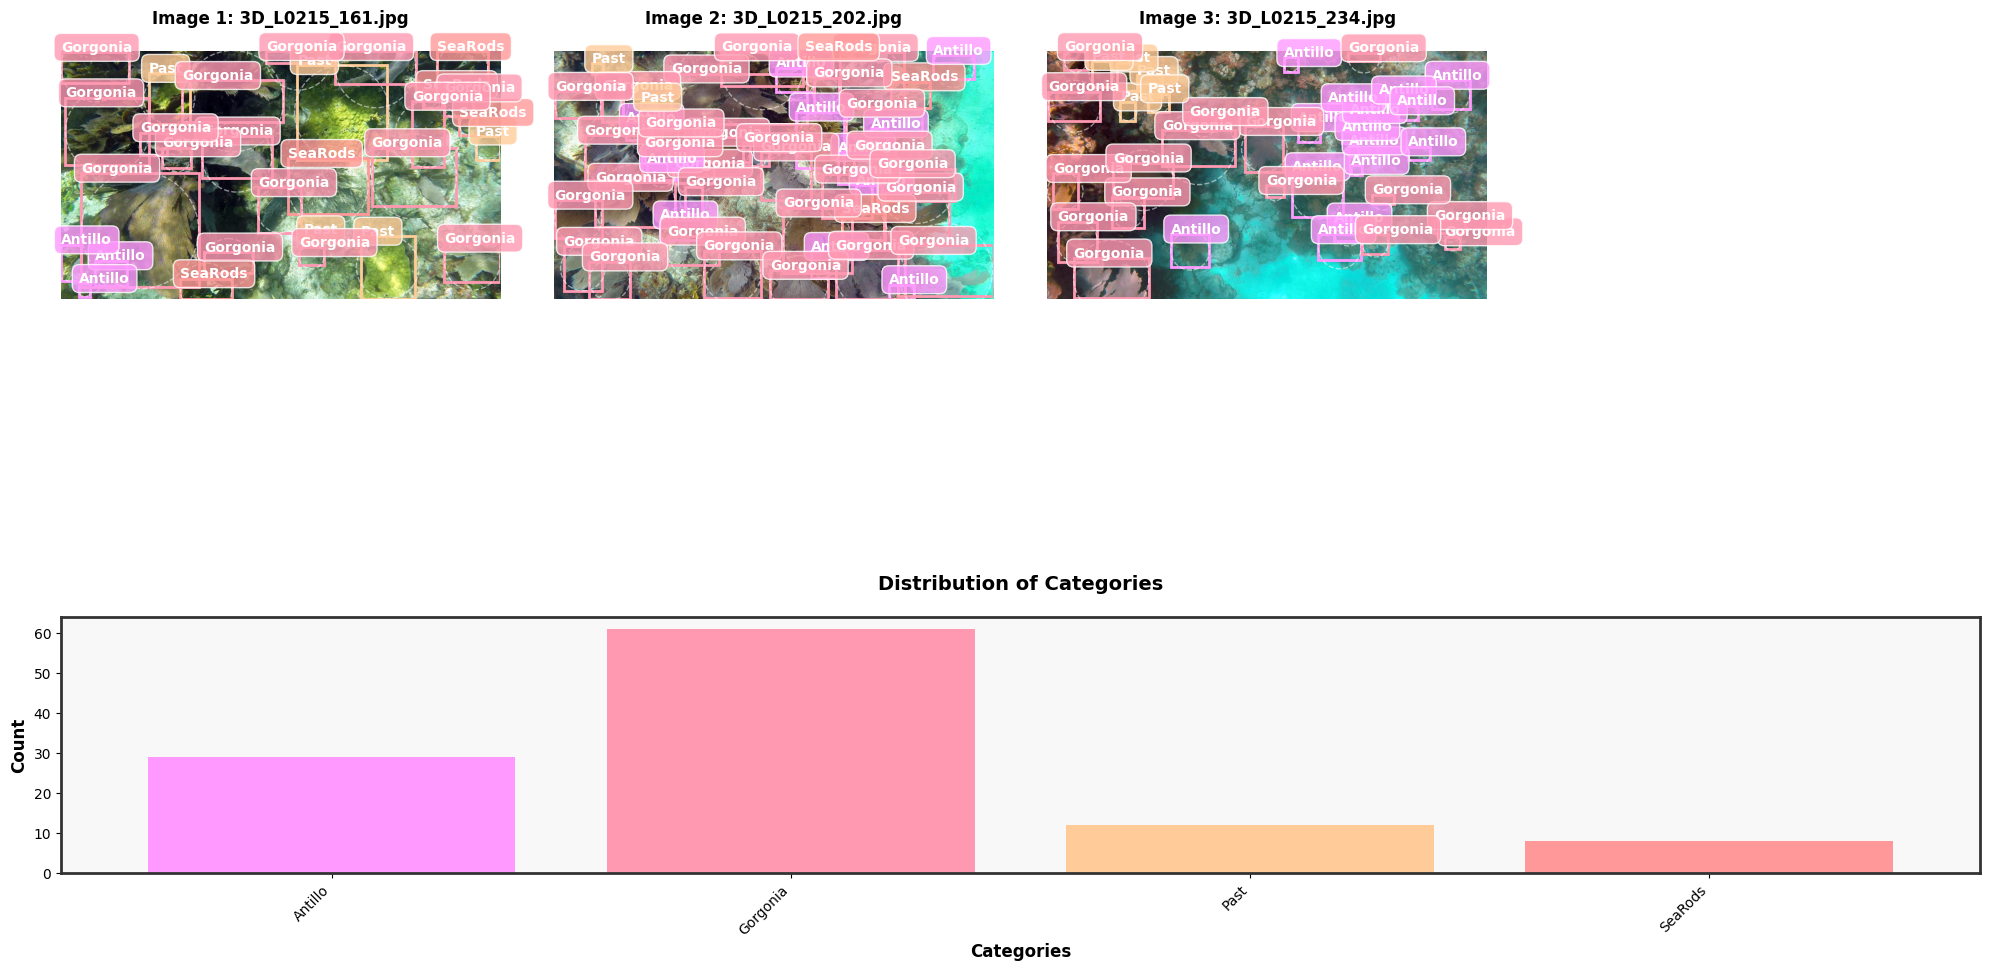

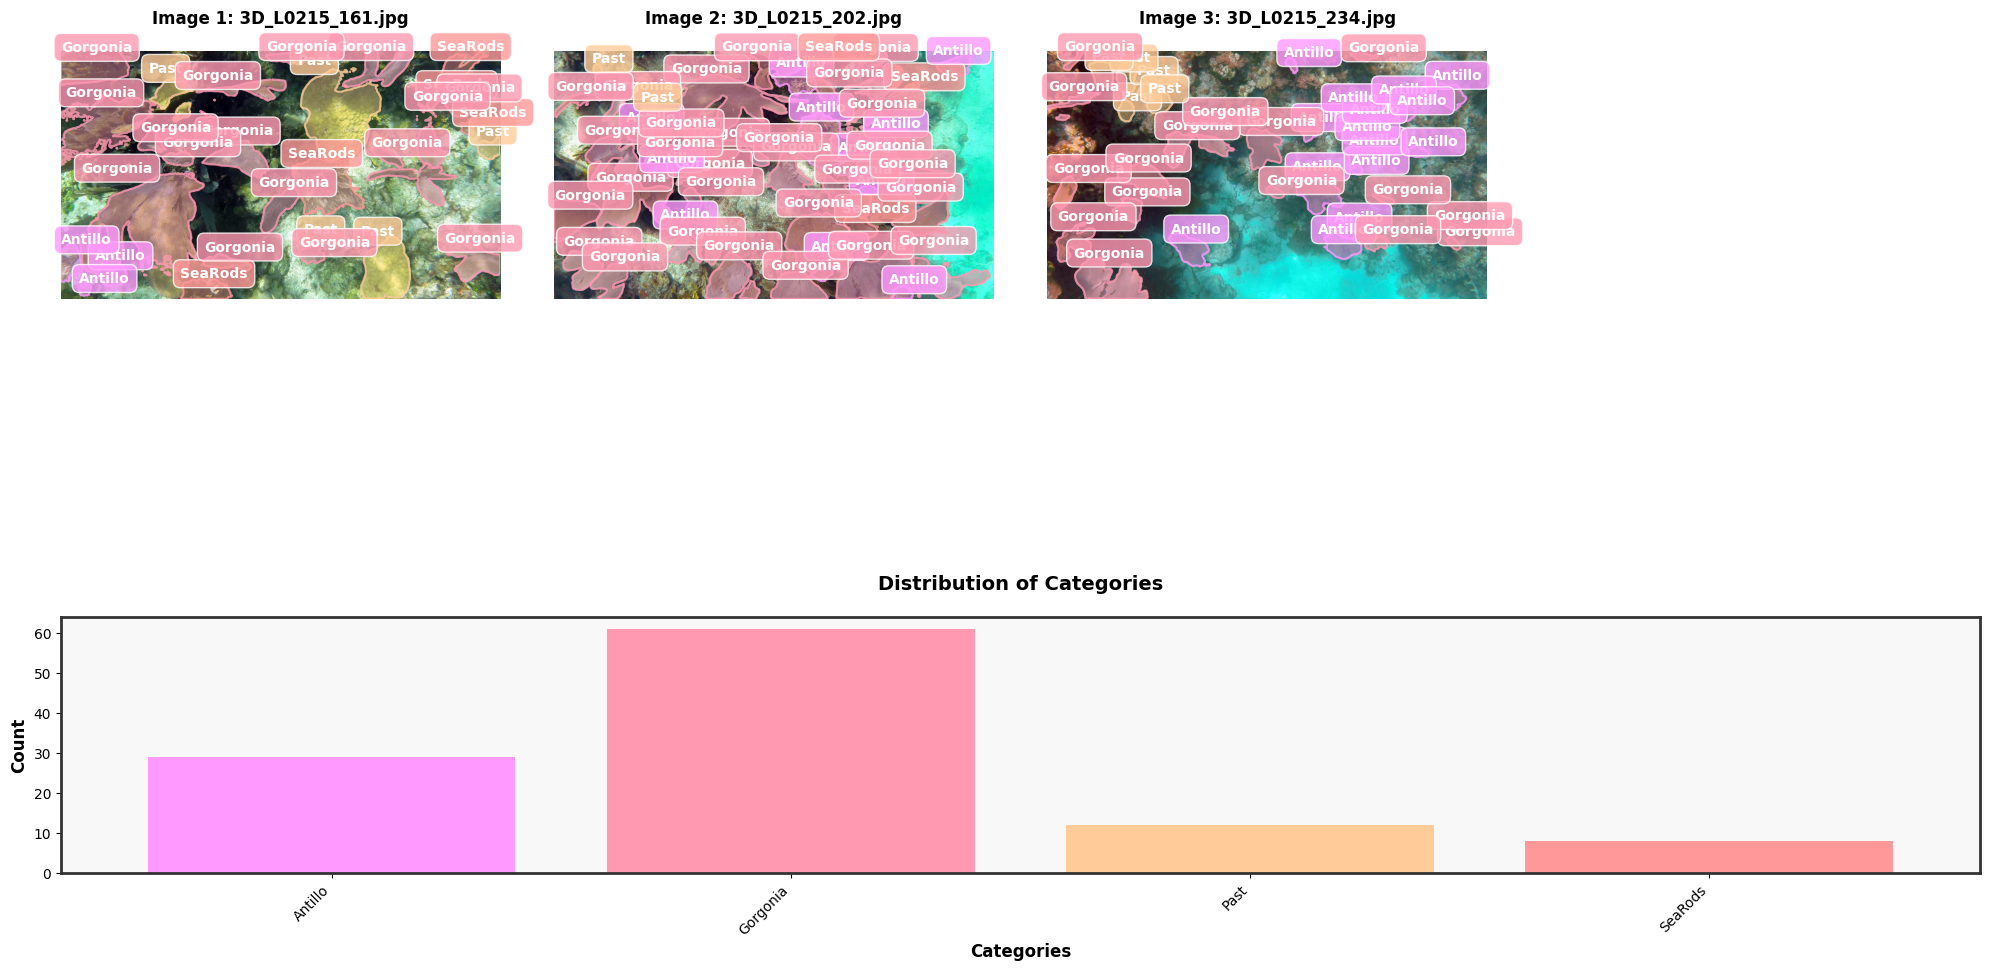

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Polygon, Circle
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_custom_colormap():
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC',
              '#99FFCC', '#FF99FF', '#FFB366', '#99FF99', '#FF99B2']
    return LinearSegmentedColormap.from_list('custom', colors, N=256)

def add_fancy_borders(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('#333333')
    ax.set_facecolor('#F8F8F8')

def create_circular_mask(ax, bbox):
    center = (bbox[0] + bbox[2]/2, bbox[1] + bbox[3]/2)
    radius = max(bbox[2], bbox[3]) / 2
    circle = Circle(center, radius, fill=False, linestyle='--', color='white', alpha=0.5)
    ax.add_patch(circle)

def enhanced_visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)
    with open(label_mapping_file) as f:
        label_map = json.load(f)

    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, num_images + 1, height_ratios=[3, 1])

    custom_cmap = create_custom_colormap()
    colors = custom_cmap(np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = plt.subplot(gs[0, idx])
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations']
                           if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            bbox = ann['bbox']
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                           fill=False, color=color, linewidth=2)
            ax.add_patch(rect)
            create_circular_mask(ax, bbox)

            ax.text(bbox[0], bbox[1] - 5, label,
                   color='white', fontsize=10, fontweight='bold',
                   bbox=dict(facecolor=color, alpha=0.8, pad=2,
                           edgecolor='white', boxstyle='round,pad=0.5'))

        add_fancy_borders(ax)
        ax.set_axis_off()
        ax.set_title(f"Image {idx + 1}: {selected_image['file_name']}",
                    pad=20, fontsize=12, fontweight='bold')

    ax_stats = plt.subplot(gs[1, :])
    categories = sorted(all_categories)
    category_counts = {cat: 0 for cat in categories}

    for ann in annotations['annotations']:
        category_counts[ann['category_name']] += 1

    bars = ax_stats.bar(categories, [category_counts[cat] for cat in categories],
                       color=[category_colors[cat] for cat in categories])

    ax_stats.set_xlabel('Categories', fontsize=12, fontweight='bold')
    ax_stats.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax_stats.set_title('Distribution of Categories', pad=20,
                      fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    add_fancy_borders(ax_stats)

    plt.tight_layout()
    return fig

def enhanced_visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)
    with open(label_mapping_file) as f:
        label_map = json.load(f)

    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, num_images + 1, height_ratios=[3, 1])

    custom_cmap = create_custom_colormap()
    colors = custom_cmap(np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = plt.subplot(gs[0, idx])
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations']
                           if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            for segment in ann['segmentation']:
                poly = np.array(segment).reshape(-1, 2)
                ax.fill(poly[:, 0], poly[:, 1], alpha=0.4, color=color)
                ax.plot(poly[:, 0], poly[:, 1], color=color, alpha=0.7)

            bbox = ann['bbox']
            ax.text(bbox[0], bbox[1] - 5, label,
                   color='white', fontsize=10, fontweight='bold',
                   bbox=dict(facecolor=color, alpha=0.8, pad=2,
                           edgecolor='white', boxstyle='round,pad=0.5'))

        add_fancy_borders(ax)
        ax.set_axis_off()
        ax.set_title(f"Image {idx + 1}: {selected_image['file_name']}",
                    pad=20, fontsize=12, fontweight='bold')

    ax_stats = plt.subplot(gs[1, :])
    categories = sorted(all_categories)
    category_counts = {cat: 0 for cat in categories}

    for ann in annotations['annotations']:
        category_counts[ann['category_name']] += 1

    bars = ax_stats.bar(categories, [category_counts[cat] for cat in categories],
                       color=[category_colors[cat] for cat in categories])

    ax_stats.set_xlabel('Categories', fontsize=12, fontweight='bold')
    ax_stats.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax_stats.set_title('Distribution of Categories', pad=20,
                      fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    add_fancy_borders(ax_stats)

    plt.tight_layout()
    return fig

def enhanced_compare_csv_files(original_csv, generated_csv):
    if not os.path.exists(original_csv) or not os.path.exists(generated_csv):
        return

    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Category Distribution - Original',
                       'Category Distribution - Generated',
                       'Annotations per Image',
                       'Image Comparison'),
        specs=[[{"type": "bar"}, {"type": "bar"}],
               [{"type": "box"}, {"type": "pie"}]]
    )

    orig_cats = df_original['label'].value_counts()
    gen_cats = df_generated['category'].value_counts()

    fig.add_trace(
        go.Bar(x=orig_cats.index, y=orig_cats.values,
               name='Original', marker_color='#2ecc71'),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(x=gen_cats.index, y=gen_cats.values,
               name='Generated', marker_color='#3498db'),
        row=1, col=2
    )

    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'

    orig_counts = df_original.groupby(image_col_orig).size()
    gen_counts = df_generated.groupby(image_col_gen).size()

    fig.add_trace(
        go.Box(y=orig_counts.values, name='Original',
               marker_color='#2ecc71', boxpoints='outliers'),
        row=2, col=1
    )
    fig.add_trace(
        go.Box(y=gen_counts.values, name='Generated',
               marker_color='#3498db', boxpoints='outliers'),
        row=2, col=1
    )

    original_images = set(df_original[image_col_orig])
    generated_images = set(df_generated[image_col_gen])

    common_images = len(original_images & generated_images)
    missing_images = len(original_images - generated_images)
    extra_images = len(generated_images - original_images)

    fig.add_trace(
        go.Pie(labels=['Common', 'Missing', 'Extra'],
               values=[common_images, missing_images, extra_images],
               marker_colors=['#2ecc71', '#e74c3c', '#f1c40f']),
        row=2, col=2
    )

    fig.update_layout(
        height=1000,
        width=1400,
        showlegend=True,
        title_text="Detailed Dataset Comparison Analysis",
        title_x=0.5,
        title_font_size=24,
        paper_bgcolor='white',
        plot_bgcolor='rgba(240,240,240,0.95)',
        legend=dict(
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=1
        ),
        font=dict(family="Arial, sans-serif", size=12)
    )

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     showline=True, linewidth=1, linecolor='rgba(0,0,0,0.3)')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     showline=True, linewidth=1, linecolor='rgba(0,0,0,0.3)')

    fig.update_traces(marker_line_color='rgb(8,48,107)',
                     marker_line_width=1.5, opacity=0.8)

    return fig

def create_statistical_dashboard(df_original, df_generated):
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Annotations per Category',
                       'Distribution of Annotations',
                       'Timeline of Annotations',
                       'Category Correlation'),
        specs=[[{"type": "bar"}, {"type": "histogram"}],
               [{"type": "scatter"}, {"type": "heatmap"}]]
    )
    return fig

# Usage
image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
annotations_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.json"
label_mapping_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/label_mapping.json"

original_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
generated_csv = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.csv"

fig_boxes = enhanced_visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3)
plt.show()

fig_polygons = enhanced_visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3)
plt.show()

try:
    fig_comparison = enhanced_compare_csv_files(original_csv, generated_csv)
    fig_comparison.show()
except Exception as e:
    print(f"Error creating comparison visualization: {str(e)}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_metrics(ground_truth, predictions, classes):
    """
    Calculate metrics similar to thesis metrics
    """
    metrics = {}

    # Calculate AP for each class
    for cls in classes:
        # Calculate precision-recall and AP for each class
        # Similar to thesis methodology
        pass

    # Calculate mAP
    metrics['mAP'] = np.mean([metrics[cls]['AP'] for cls in classes])

    # Calculate TP, FP per class
    for cls in classes:
        cm = confusion_matrix(ground_truth[cls], predictions[cls])
        metrics[cls]['TP'] = cm[1,1]
        metrics[cls]['FP'] = cm[0,1]

    # Calculate mIoU if masks available
    metrics['mIoU'] = calculate_mean_iou(ground_truth_masks, predicted_masks)

    return metrics

def compare_with_thesis_results(sam_results):
    """
    Compare SAM results with thesis models
    """
    # Results from thesis Table 5
    thesis_results = {
        'YOLOv2': {
            'mAP': 0.376,
            'mIoU': 0.286
        },
        'YOLOv3': {
            'mAP': 0.321,
            'mIoU': 0.358
        },
        'Faster_RCNN': {
            'mAP': 0.113
        },
        'RetinaNet': {
            'mAP': 0.134
        }
    }

    comparison_df = pd.DataFrame([
        {'Model': 'SAM',
         'mAP': sam_results['mAP'],
         'mIoU': sam_results['mIoU'],
         'Runtime': sam_results['runtime']
        },
        *[{'Model': model, **metrics}
          for model, metrics in thesis_results.items()]
    ])

    return comparison_df

def per_class_comparison(sam_results):
    """
    Compare per-class metrics with thesis results
    Focus on challenging classes identified in thesis:
    - Apalm (undetectable)
    - Ssid (rare, only detected by YOLOv2)
    - Past (highest AP)
    - Antilo (second best AP)
    """
    # Results from thesis Table 5
    # Add per class comparison
    pass